# Import Libraries

In [1]:
import keras
import gc
import tensorflow as tf
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


In [2]:
# Set random seeds
np.random.seed(0)
tf.set_random_seed(0)

# Open Data

In [3]:
# Open data, csv files should be in same folder as notebook.
notebook_dir = %pwd

items = pd.read_csv(notebook_dir + "/items.csv")
shops_data = pd.read_csv(notebook_dir + "/shops.csv")
sales_train = pd.read_csv(notebook_dir + "/sales_train.csv")
test = pd.read_csv(notebook_dir + "/test.csv")
sample_submission = pd.read_csv(notebook_dir + "/sample_submission.csv")
item_category = pd.read_csv(notebook_dir + "/item_categories.csv")

# Exploratory Data Analysis

In [4]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [5]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [6]:
sample_submission

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [15]:
shops_data['shop_name']

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

Several shops are very similar in name (0 and 57, 1 and 58, 10 and 11). It might be advantageous to merge these.

In [17]:
print('Amount of train samples: ' + str(len(sales_train.index)))
print(sales_train.describe())

# sales_train has duplicate rows which will influence training, drop duplicate rows
sales_train.drop_duplicates(inplace = True)
print('Amount of unique train samples: ' + str(len(sales_train.index)))

Amount of train samples: 2935843
       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06  2.935843e+06
mean     1.456991e+01  3.300171e+01  1.019723e+04  8.908535e+02  1.242641e+00
std      9.422992e+00  1.622698e+01  6.324293e+03  1.729801e+03  2.618837e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03
Amount of unique train samples: 2935843


{'whiskers': [<matplotlib.lines.Line2D at 0x7f3c02a6f978>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3c02a83048>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3c02a6f588>],
 'medians': [<matplotlib.lines.Line2D at 0x7f3c02a836d8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f3c02a83a20>],
 'means': []}

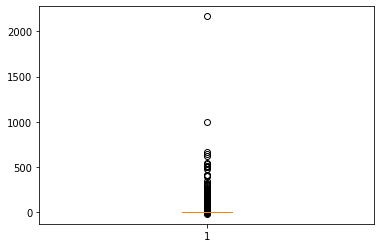

In [7]:
plt.boxplot(sales_train['item_cnt_day'])

As we can see, there are quite a few outliers with some people buying up to 2000+ items in one transaction. This will heavily skew our predicitons, and hence during preprocessing we should get rid of these outliers.

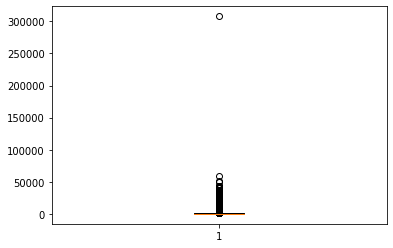

              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0


In [8]:
plt.boxplot(sales_train['item_price'])
plt.show()
print(sales_train[sales_train['item_price'] < 0])

As we can see the price also has some outliers with some prices being extremely high or below 0.

In [10]:
sales_train.groupby(by=['date_block_num'])['item_cnt_day'].count()

date_block_num
0     115689
1     108613
2     121347
3      94109
4      91759
5     100403
6     100548
7     104772
8      96137
9      94202
10     96736
11    143246
12     99349
13     89829
14     92732
15     77906
16     78528
17     82408
18     78759
19     86614
20     73157
21     79361
22     86428
23    130785
24     88522
25     71808
26     69977
27     56274
28     54548
29     54617
30     55549
31     57029
32     50588
33     53514
Name: item_cnt_day, dtype: int64

as we can see not all months have the same amount of rows. This might skew training.

In [20]:
print('test rows:', len(test))
test.head()

test rows: 214200


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Data Leakages
During EDA no Data Leakages became apparant so we didn't use any during our training.

# Data Preprocessing and Generation

### Product price
We use the price of the last recorded month in a particular store as an estimate for the price in date_block 34.
This allows us to use the price for training, and to better predict the eventual amount of sales.

In [10]:
most_recent_prices = sales_train.groupby(['shop_id', 'item_id'], as_index=False)['item_price'].last()
print(most_recent_prices)

        shop_id  item_id  item_price
0             0       30       265.0
1             0       31       434.0
2             0       32       221.0
3             0       33       347.0
4             0       35       247.0
...         ...      ...         ...
424119       59    22154       999.0
424120       59    22155       149.0
424121       59    22162       349.0
424122       59    22164       699.0
424123       59    22167       299.0

[424124 rows x 3 columns]


### Merge Shops

In [ ]:
# Merge shops with same name as found in EDA
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### Item category
Adding item category to easier distinguish between different types of products

In [11]:
item_category_map = items[['item_id', 'item_category_id']]
item_category_map

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
...,...,...
22165,22165,31
22166,22166,54
22167,22167,49
22168,22168,62


### Month
Adding Month index to make model able to distinguish between high and low selling months

In [12]:
month_index = sales_train['date_block_num'] % 12
month_index

0          0
1          0
2          0
3          0
4          0
          ..
2935844    9
2935845    9
2935846    9
2935847    9
2935848    9
Name: date_block_num, Length: 2935843, dtype: int64

### Days in Month

In [13]:
days_in_month = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])

### Create dataframe for competition predictions
Test DataFrame needs same columns as training set

In [14]:
test_data = pd.merge(test, most_recent_prices, on=['shop_id', 'item_id'], how='left')
test_data = pd.merge(test_data, item_category_map, on=['item_id'], how='left')
test_data['date_block_num'] = 34
test_data['month_index'] = test_data['date_block_num'] % 12
test_data['month_days'] = test_data['month_index'].map(days_in_month).astype(np.int8)
test_data

,ID,shop_id,item_id,item_price,item_category_id,date_block_num,month_index,month_days
0,0,5,5037,749.5,19,34,10,30
1,1,5,5320,NaN,55,34,10,30
2,2,5,5233,1199.0,19,34,10,30
3,3,5,5232,599.0,23,34,10,30
4,4,5,5268,NaN,20,34,10,30
...,...,...,...,...,...,...,...,...
214195,214195,45,18454,99.0,55,34,10,30
214196,214196,45,16188,NaN,64,34,10,30
214197,214197,45,15757,199.0,55,34,10,30
214198,214198,45,19648,NaN,40,34,10,30


In [15]:
np.sum(test_data['item_price'].isnull())

102796

As we can see, the item_price is still empty in roughly half of the cases. Since the item price during training is always present, it will be hard for the model to predict what the amount of sales will be for an unknown price. Hence we need to find a way to fill in these values.

We use the average price of an item in the category per shop in last month:

In [16]:
sales_train_with_item_category = pd.merge(sales_train, item_category_map, on=['item_id'], how='left')
category_avg_price_map = sales_train_with_item_category[sales_train_with_item_category['date_block_num'] == 33].groupby(['shop_id', 'item_category_id'], as_index=False)['item_price'].mean()
print(category_avg_price_map)

      shop_id  item_category_id    item_price
0           2                 3   1649.357143
1           2                 6   2319.857143
2           2                 7   2126.000000
3           2                12  33656.666667
4           2                15  16990.000000
...       ...               ...           ...
1755       59                72   1083.615385
1756       59                73    729.500000
1757       59                75   1626.363636
1758       59                79    802.550000
1759       59                83    129.000000

[1760 rows x 3 columns]


In [17]:
nan_replacement = pd.merge(test_data[['shop_id', 'item_category_id']], category_avg_price_map, on=['shop_id', 'item_category_id'], how='left')
nan_replacement

,shop_id,item_category_id,item_price
0,5,19,1548.945946
1,5,55,340.886792
2,5,19,1548.945946
3,5,23,1786.225455
4,5,20,3182.194030
...,...,...,...
214195,45,55,334.277108
214196,45,64,1157.333333
214197,45,55,334.277108
214198,45,40,326.846154


We now have the item prices that we can replace the nan values with per shop, now all we have to do is combine test_data with nan_replacement:

In [18]:
test_data = test_data.combine_first(nan_replacement)
test_data = test_data[['ID', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_category_id', 'month_index', 'month_days']]
test_data

,ID,date_block_num,shop_id,item_id,item_price,item_category_id,month_index,month_days
0,0,34,5,5037,749.500000,19,10,30
1,1,34,5,5320,340.886792,55,10,30
2,2,34,5,5233,1199.000000,19,10,30
3,3,34,5,5232,599.000000,23,10,30
4,4,34,5,5268,3182.194030,20,10,30
...,...,...,...,...,...,...,...,...
214195,214195,34,45,18454,99.000000,55,10,30
214196,214196,34,45,16188,1157.333333,64,10,30
214197,214197,34,45,15757,199.000000,55,10,30
214198,214198,34,45,19648,326.846154,40,10,30


### Aggregate preprocessed features

In [19]:
# Create new dataframe to use in training without redundant columns
preprocessed_sales_train = sales_train.drop(columns=['date'])
# Group by date, shop and item
preprocessed_sales_train_grouped = preprocessed_sales_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).sum()
# Add item category
preprocessed_sales_train_grouped = pd.merge(preprocessed_sales_train_grouped, item_category_map, on=['item_id'], how='left')
# Add month index
preprocessed_sales_train_grouped['month_index'] = preprocessed_sales_train_grouped['date_block_num'] % 12
# Add month days
preprocessed_sales_train_grouped['month_days'] = preprocessed_sales_train_grouped['month_index'].map(days_in_month).astype(np.int8)

print(preprocessed_sales_train_grouped)

         date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0                     0        0       32       884.0           6.0   
1                     0        0       33      1041.0           3.0   
2                     0        0       35       247.0           1.0   
3                     0        0       43       221.0           1.0   
4                     0        0       51       257.0           2.0   
...                 ...      ...      ...         ...           ...   
1609119              33       59    22087       357.0           6.0   
1609120              33       59    22088       238.0           2.0   
1609121              33       59    22091       179.0           1.0   
1609122              33       59    22100       629.0           1.0   
1609123              33       59    22102      1250.0           1.0   

         item_category_id  month_index  month_days  
0                      40            0          31  
1                      37            0   

We have now created a training dataframe, but as we saw during EDA there are many outliers with respect to the item_count_day, lets plot this.

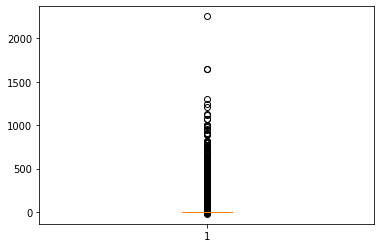

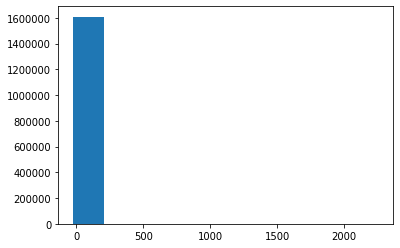

In [20]:
plt.figure(1)
plt.boxplot(preprocessed_sales_train_grouped['item_cnt_day'])
plt.figure(2)
plt.hist(preprocessed_sales_train_grouped['item_cnt_day'])
plt.show()

As we can see in the aggregated dataframe there are also quite a few outliers while almost all values fall into the first box. That is why we will clip values to [0, 20] to prevent these outliers of influencing predictions too much. We assume that over the span of a month products only get sold a positive amount of times.

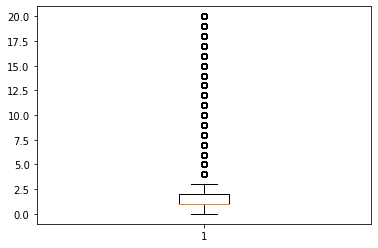

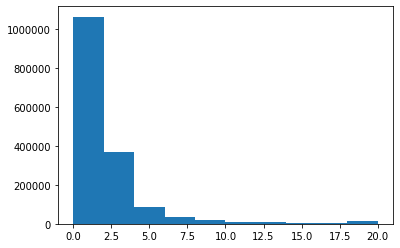

In [21]:
preprocessed_sales_train_grouped['item_cnt_day'] = preprocessed_sales_train_grouped['item_cnt_day'].clip(0, 20)
plt.figure(1)
plt.boxplot(preprocessed_sales_train_grouped['item_cnt_day'])
plt.figure(2)
plt.hist(preprocessed_sales_train_grouped['item_cnt_day'])
plt.show()

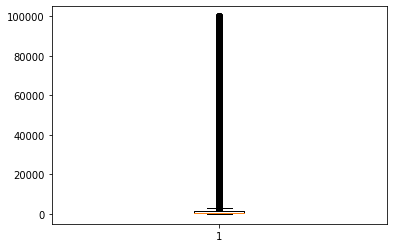

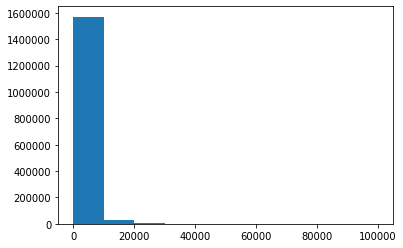

In [22]:
# Get rid of items with price > 100000
preprocessed_sales_train_grouped = preprocessed_sales_train_grouped[preprocessed_sales_train_grouped['item_price'] < 100000]
# Replace negative price with median
median = preprocessed_sales_train_grouped[(preprocessed_sales_train_grouped['shop_id']==32)&(preprocessed_sales_train_grouped['item_id']==2973)&(preprocessed_sales_train_grouped['date_block_num']==4)&(preprocessed_sales_train_grouped['item_price']>0)]['item_price'].median()
preprocessed_sales_train_grouped[preprocessed_sales_train_grouped['item_price'] < 0]['item_price'] = median

plt.figure(1)
plt.boxplot(preprocessed_sales_train_grouped['item_price'])
plt.figure(2)
plt.hist(preprocessed_sales_train_grouped['item_price'])
plt.show()

## Mean encodings

In the extentions video mean encodings for time series are discussed. We use those (lagged values) here.
First we add lagged sales for product shop combos. We dont have to do the train/validation split before introducing lagged values.

In [23]:
month_offsets = [1, 2, 3, 4, 5, 6, 12]

# We shift the month by offset and rename the item_cnt_day to previous_month_count to get the previous amount.
for offset in month_offsets:
    sales_lagged = preprocessed_sales_train_grouped.copy()[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
    sales_lagged['date_block_num'] += offset
    sales_lagged.rename(columns={"item_cnt_day": f"previous_{offset}month_shop_item_sales"}, inplace=True)
    preprocessed_sales_train_grouped = pd.merge(preprocessed_sales_train_grouped, sales_lagged, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
    
    # Do same for test_data
    test_data = pd.merge(test_data, sales_lagged, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

Now we also add lagged values for total shop sales of last month

In [24]:
for offset in month_offsets:
    shop_sales_lagged = preprocessed_sales_train_grouped.groupby(['date_block_num', 'shop_id'], as_index=False)['item_cnt_day'].sum()
    shop_sales_lagged['date_block_num'] += offset
    shop_sales_lagged.rename(columns={"item_cnt_day": f"previous_{offset}month_shop_sales"}, inplace=True)
    preprocessed_sales_train_grouped = pd.merge(preprocessed_sales_train_grouped, shop_sales_lagged, on=['date_block_num', 'shop_id'], how='left').fillna(0)
    
    test_data = pd.merge(test_data, shop_sales_lagged, on=['date_block_num', 'shop_id'], how='left').fillna(0)

Now we also add lagged value for total item sales of last month

In [25]:
for offset in month_offsets:
    item_sales_lagged = preprocessed_sales_train_grouped.groupby(['date_block_num', 'item_id'], as_index=False)['item_cnt_day'].sum()
    item_sales_lagged['date_block_num'] += offset
    item_sales_lagged.rename(columns={"item_cnt_day": f"previous_{offset}month_item_sales"}, inplace=True)
    preprocessed_sales_train_grouped = pd.merge(preprocessed_sales_train_grouped, item_sales_lagged, on=['date_block_num', 'item_id'], how='left').fillna(0)
    
    test_data = pd.merge(test_data, item_sales_lagged, on=['date_block_num', 'item_id'], how='left').fillna(0)

In [26]:
# Dont use data from first 12 months (have no lag values)
preprocessed_sales_train_grouped = preprocessed_sales_train_grouped[preprocessed_sales_train_grouped['date_block_num'] >= 12]

print(preprocessed_sales_train_grouped)
print(test_data)

         date_block_num  shop_id  item_id  item_price  item_cnt_day  \
687633               12        2       32       119.0           1.0   
687634               12        2       33       199.0           1.0   
687635               12        2       99       149.0           1.0   
687636               12        2      482      6600.0           2.0   
687637               12        2      485       300.0           1.0   
...                 ...      ...      ...         ...           ...   
1608406              33       59    22087       357.0           6.0   
1608407              33       59    22088       238.0           2.0   
1608408              33       59    22091       179.0           1.0   
1608409              33       59    22100       629.0           1.0   
1608410              33       59    22102      1250.0           1.0   

         item_category_id  month_index  month_days  \
687633                 40            0          31   
687634                 37            0 

# Validation
The Train/Test split is a time based split. The test data is the month (date_block_num 34) directly after the data in the train data (date_block_num 12 - 33). Hence for training we will use a time based split as well by using block 12 - 32 as training and using 33 as validation.

After submitting the csv a few times and observing the loss for the public and private leaderboard to be almost identical we take these are both randomly sampled from the test set.

### Train Validation Split

In [27]:
X = preprocessed_sales_train_grouped.drop(columns=['item_cnt_day'])
y = preprocessed_sales_train_grouped['item_cnt_day']

In [28]:
# Time based validation gives worse result on leaderboard, probably due to not training on last month.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X[X['date_block_num'] < 33]
y_train = y[:len(X_train.index)]
X_val = X[len(X_train.index):]
y_val = y[len(X_train.index):]

### Random Forest
We use Random forest to plot accuracy against amount of trees to get an idea how good our features work with tree besed classifiers.

In [29]:
rf = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
predictions = []
r2s = []
accuracys = []

for tree in rf.estimators_:
    predictions.append(tree.predict_proba(X_val.fillna(0))[None, :])
    
predictions = np.vstack(predictions)

In [31]:
# Compute cumulative average over predictions
cum_mean = np.cumsum(predictions, axis=0)/np.arange(1, predictions.shape[0] + 1)[:, None, None]

# Compute score for each n_estimator value
for pred in cum_mean:
    r2s.append(r2_score(y_val, np.argmax(pred, axis=1)))
    accuracys.append(accuracy_score(y_val, np.argmax(pred, axis=1)))

16891

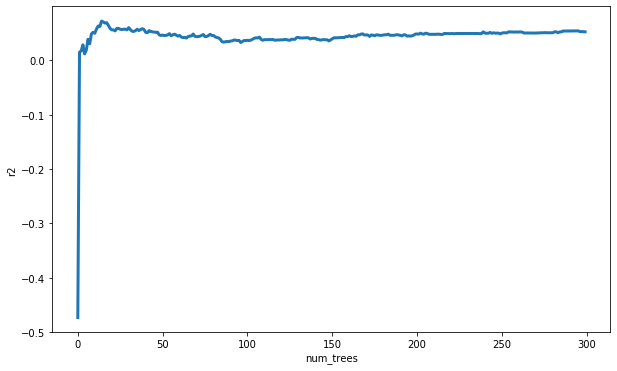

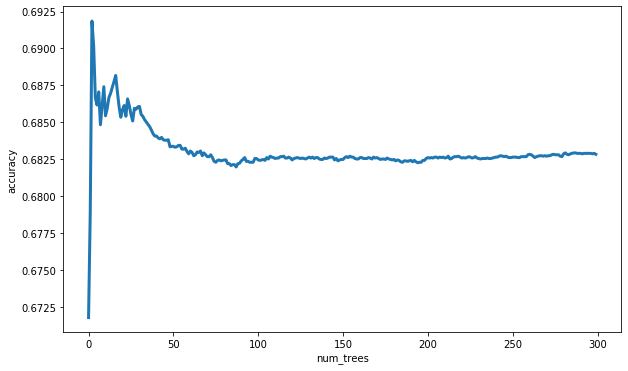

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(r2s, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('r2')

plt.figure(figsize=(10, 6))
plt.plot(accuracys, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('accuracy')
plt.plot()

del rf
del predictions
del r2s
del accuracys
gc.collect()

# Training

### Linear Regression
We fit a linear regression model to the data.

In [33]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_val.values)

print('Validation R-squared for linreg is %f' % r2_score(y_val, pred_lr))

Validation R-squared for linreg is 0.308857


### XGBoost (form of GBDT)
We optimise the metric squarederror (built into XGBoost) which is the same as optimising the root squared error.

In [34]:
colsample_bytree = 0.5
subsample = 0.8
min_child_weight = 3
learning_rate = 0.01
max_depth = 10
alpha = 500
n_estimators = 1000

xgb_reg = xgb.XGBRegressor(tree_method = 'gpu_hist', objective = 'reg:squarederror', 
                          colsample_bytree = colsample_bytree, learning_rate = learning_rate, max_depth = max_depth, 
                          alpha = alpha, n_estimators = n_estimators, min_child_weight = min_child_weight,
                          subsample = subsample)

xgb_reg.fit(X_train, y_train)

train_preds = xgb_reg.predict(X_train)
rounded_train_preds = np.around(train_preds)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
model_train_score = np.sum(y_train.to_numpy() == rounded_train_preds) / len(y_train.index)

print('Train R-squared is %f' % r2_score(y_train, train_preds))
print(f'Train RSME: {train_rmse}')
print(f'model train score: {model_train_score}')
print('')


preds = xgb_reg.predict(X_val)
rounded_preds = np.around(preds)
rmse = np.sqrt(mean_squared_error(y_val, preds))
model_validation_score = np.sum(y_val.to_numpy() == rounded_preds) / len(y_val.index)

print('Validation R-squared is %f' % r2_score(y_val, preds))
print(f'Validation RSME: {rmse}')
print(f'model validation score: {model_validation_score}')

/home/dustin/anaconda3/envs/coursera-aml/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dustin/anaconda3/envs/coursera-aml/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Train R-squared is 0.892143
Train RSME: 0.8239213256610128
model train score: 0.7862826593976524

Validation R-squared is 0.676486
Validation RSME: 1.4427192123221724
model validation score: 0.7155500570993528


Our XGBoost model has a validation score of ~0.694. The model performs several orders of magnitude better than random, but is still far from ideal.

The discripancy between train and validation score is quite sizeable which means we are overfitting but further regularizing doesnt improve RMSE so we will leave it here.

### Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_val)
print('Validation R-squared for randforest is %f' % r2_score(y_val, pred_rf))

Validation R-squared for randforest is 0.053322


# Ensembling
## Stacking

# Predicting competition data
Using our XGB model

In [36]:
xgb_predictor = xgb.XGBRegressor(tree_method = 'gpu_hist', objective = 'reg:squarederror', 
                          colsample_bytree = colsample_bytree, learning_rate = learning_rate, max_depth = max_depth, 
                          alpha = alpha, n_estimators = n_estimators)
xgb_predictor.fit(X, y)

xgb_predictor.predict(test_data.drop(columns=['ID']))

/home/dustin/anaconda3/envs/coursera-aml/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dustin/anaconda3/envs/coursera-aml/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


array([ 1.2624526 ,  1.33399522,  1.10743237, ...,  0.98104256,
        1.09485579,  1.08862734], dtype=float32)

# Build submission csv

In [37]:
submission = pd.DataFrame()
submission['ID'] = test_data['ID']
submission['item_cnt_month'] = xgb_predictor.predict(test_data.drop(columns=['ID']))

submission_rounded = submission.copy()
submission_rounded['item_cnt_month'] = np.around(submission['item_cnt_month'])

submission

,ID,item_cnt_month
0,0,1.262453
1,1,1.333995
2,2,1.107432
3,3,0.898500
4,4,1.379089
...,...,...
214195,214195,0.984271
214196,214196,1.031210
214197,214197,0.981043
214198,214198,1.094856


In [38]:
submission.to_csv('submission.csv', index=False)
submission_rounded.to_csv('submission_rounded.csv', index=False)

# TODO
1. Advanced Features II
2. Ensembles